### RQ Analyser for different sources

#### Imports

In [1]:
import joblib
import os
import re

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime

import RQ_helper


Working directory: /home/wvdp/Documents/scratch
nptdms not available, skip for Argonne data.
No local midas libary installed


/home/wvdp/Documents/pycrp/pycrp/_event.py:34: UserWarning: No MIDAS reader found. See readme for how to install a python MIDAS interface.
  warnings.warn(


#### Constants

In [2]:
# Directories
globus_dir = "/project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/"
output_dir = globus_dir+"output/"

# Default matplotlib colours
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Field initizlisation
source_dict = {}
config = None


#### Load data

In [3]:
fn_list = glob(globus_dir+"processed/OFResults*.joblib")

for i, fn in enumerate(fn_list):
    series = re.search("OFResults_(.*?)_", fn).group(1)
    path = re.search("OFResults_(.*).joblib", fn).group(1)
    print("---",series, path)

    source_dict[series] = {}
    source_dict[series]['path'] = path
    source_dict[series]['fn'] = fn
    source_dict[series]['creation_time'] = os.path.getctime(source_dict[series]['fn'])
    source_dict[series]['data'] = joblib.load(fn)
    source_dict[series]['color'] = colors[i]
    exec(source_dict[series]['data']['config_str'])
    source_dict[series]['config'] = config
    source_dict[series]['helper'] = RQ_helper.RQ_helper(source_dict[series]['data'], config, path, output_dir)
    del config
    print(series, datetime.fromtimestamp(source_dict[series]['creation_time']),fn)

series_names = list(source_dict.keys())

# check if all configs are the same
configs = [source_dict[series]['config'] for series in series_names]
for configs_i in configs:
    if configs_i != configs[0]:
        raise ValueError("Not all configs are the same")
config = configs[0]

--- AmBe AmBe_August
RQ helper is initialised
AmBe 2023-03-11 14:22:58 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/OFResults_AmBe_August.joblib
--- Background Background_workingpoint_August
RQ helper is initialised
Background 2023-02-08 15:30:25 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/OFResults_Background_workingpoint_August.joblib
--- Ba133 Ba133_August
RQ helper is initialised
Ba133 2023-03-11 14:59:42 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/OFResults_Ba133_August.joblib
--- Co60 Co60_August
RQ helper is initialised
Co60 2023-03-11 12:55:40 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/OFResults_Co60_August.joblib


#### Add new fields

For list of existing fields: 
https://bitbucket.org/phys-ricochet/pycrp/src/master/pycrp/processing/

In [4]:
raw_trace_length = config.real_trace_length

for series, sample_d in source_dict.items():
    RQ_data = sample_d["data"]

    # Time since previous triggered pulse
    trig_loc_tr = RQ_data["trig_loc"]
    num_traces_file = max(RQ_data["trig_traceidx"]+1)
    trace_loc = RQ_data["trig_traceidx"]
    file_loc = RQ_data["trig_fileidx"]
    num_files = max(RQ_data["trig_fileidx"]+1)

    trig_loc_total = (file_loc*num_traces_file+trace_loc) * raw_trace_length+trig_loc_tr
    time_diffs_trig = np.diff(trig_loc_total[RQ_data["trig_ch"] == 1])/config.Fs
    time_diffs_trig = np.insert(time_diffs_trig, 0, trig_loc_tr[0])
    time_diffs_noise = np.diff(trig_loc_total[RQ_data["trig_ch"] == 0])/config.Fs
    time_diffs_noise = np.insert(time_diffs_noise, 0, trig_loc_tr[0])

    RQ_data["time_diff_prev_trig"] = np.empty_like(RQ_data['trig_ch'], dtype=float)
    RQ_data["time_diff_prev_trig"][RQ_data["trig_ch"] == 1] = time_diffs_trig
    RQ_data["time_diff_prev_trig"][RQ_data["trig_ch"] == 0] = time_diffs_noise
    RQ_data["trig_loc_total"] = trig_loc_total

    # Maximum value of the tail, baseline subtracted
    RQ_data["MaxTailRel_CH1"] = RQ_data["MaxTail_CH1"]-RQ_data["MeanBase_CH1"]
    RQ_data["TailAmpFraction_CH1"] = RQ_data["MaxTailRel_CH1"] / RQ_data["Amplitude_CH1"]
    # Maximum value of the head, baseline subtracted
    RQ_data["MaxHeadRel_CH1"] = RQ_data["MaxHead_CH1"]-RQ_data["MeanBase_CH1"]
    RQ_data["HeadAmpFraction_CH1"] = RQ_data["MaxHeadRel_CH1"] / RQ_data["Amplitude_CH1"]

    # Data quality cuts
    ## Pycrp trigger channel
    ## Tail amplitude needs to be less than 99% of the pulse amplitude
    ## Head amplitude needs to be less than 99% of the pulse amplitude
    ## OFL time needs to be greater than 0 and less than 5 ms -> TODO, this was the older version.
    mask_trig_quality = (RQ_data['trig_ch'] == 1) &\
        (RQ_data["TailAmpFraction_CH1"] < 0.99) &\
        (RQ_data["HeadAmpFraction_CH1"] < 0.99) &\
        (RQ_data['OFL_time_CH1'] > -0.005) & (RQ_data['OFL_time_CH1'] < 0.010)
       #(RQ_data["time_diff_prev_trig"] > 0.1) &\

    if "Fe55" in series:
        mask_trig_quality = mask_trig_quality &\
            (RQ_data['BaselineVariance_CH1'] < 3.5e-6) &\
            (np.abs(RQ_data['BaselineSlope_CH1']) < 1e-7) &\
            (RQ_data["trig_amp"] > 1.5)

    elif "August" in series:
        mask_trig_quality = mask_trig_quality &\
            (RQ_data['BaselineVariance_CH1'] < 2e-5) &\
            (np.abs(RQ_data['BaselineSlope_CH1']) < 4e-7)

    # Define Masks
    ## Noise triggers
    mask_noise = (RQ_data['trig_ch'] == 0) & (RQ_data["trig_fileidx"]==1)
    ## TES-like pulses
    mask_tes = (RQ_data['trig_ch'] == 1) & (RQ_data['Amplitude_CH1'] /RQ_data['Integral_CH1'] > 0.003) & (RQ_data['Amplitude_CH1'] > 0.02) & (RQ_data["trig_fileidx"]==1)
    ## Crystal-like pulses
    mask_crystal = mask_trig_quality & (~mask_tes) & (RQ_data["trig_fileidx"]==1)
    ## Weird traces
    mask_noisy = ~mask_noise & ~mask_trig_quality & ~mask_tes

    RQ_data["mask_crystal"] = mask_crystal
    RQ_data["mask_tes"] = mask_tes
    RQ_data["mask_noise"] = mask_noise

    print(f"\n--- {series}, pre-trigger: {config.PRE_TRIG}, post-trigger: {config.POST_TRIG}, baseline: {config.BaseLength}, tail: {config.TailLength} ---")
    print('Original triggered events:', sum(RQ_data['trig_ch']))
    print('After quality cuts:', sum(mask_trig_quality))
    print('TES-like pulses:', sum(mask_tes))
    print('Crystal-like pulses', sum(mask_crystal))
    trig_amp_threshold = RQ_data['trig_config']['CH1']['trigger_threshold']
    print("The auto threshold was set to", RQ_data['trig_config']['CH1']
          ['trigger_threshold_auto'], "which was calculated to be", trig_amp_threshold)



--- AmBe, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, tail: 4096 ---
Original triggered events: 142080
After quality cuts: 127265
TES-like pulses: 103
Crystal-like pulses 11778
The auto threshold was set to None which was calculated to be 4

--- Background, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, tail: 4096 ---
Original triggered events: 76080
After quality cuts: 71365
TES-like pulses: 35
Crystal-like pulses 5810
The auto threshold was set to None which was calculated to be 4

--- Ba133, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, tail: 4096 ---
Original triggered events: 63810
After quality cuts: 57654
TES-like pulses: 57
Crystal-like pulses 6203
The auto threshold was set to None which was calculated to be 4

--- Co60, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, tail: 4096 ---
Original triggered events: 187044
After quality cuts: 159048
TES-like pulses: 148
Crystal-like pulses 16465
The auto threshold was set to None which was calculat

#### Show some noise and pulse traces

Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 10/10 [00:00<00:00, 11.15it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 10/10 [00:00<00:00, 11.51it/s]


ValueError: x and y must have same first dimension, but have shapes (1229,) and (1228,)

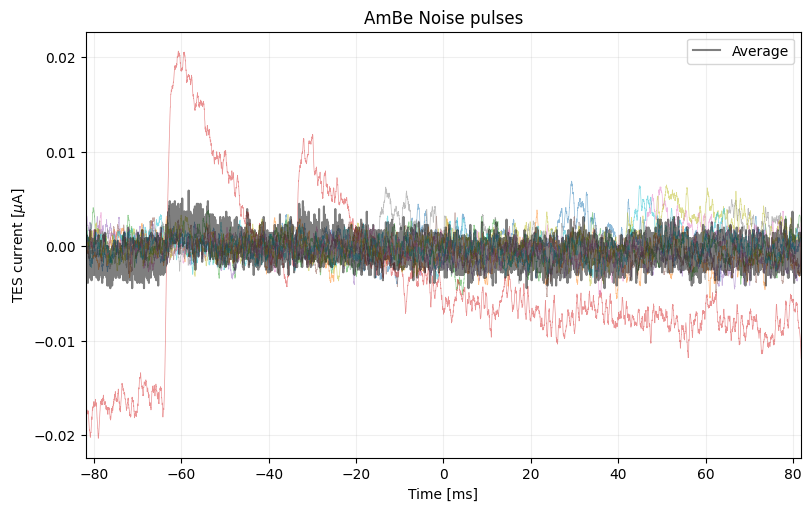

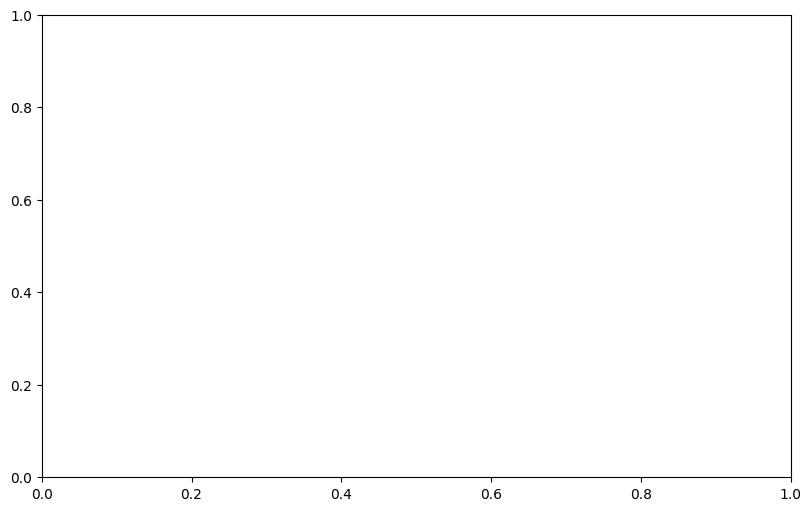

In [5]:
series = "Co60"
n_pulses = 10

for series,sample_d in source_dict.items():
    RQ_data = sample_d["data"]
    helper = sample_d["helper"]

    # Noise pulses
    mask_noise = RQ_data["mask_noise"]
    mask_sample = RQ_helper.sample_from_mask(mask_noise,n_pulses)
    times, traces = helper.plot_traces(mask_sample, series+" Noise pulses", plot_data=0, nsmooth=100, plot_mean=0.5, pre_trig=config.PRE_TRIG, post_trig=config.POST_TRIG)

    # TES-like pulses
    mask_tes = RQ_data["mask_tes"]
    mask_sample = RQ_helper.sample_from_mask(mask_tes,n_pulses)
    times, traces = helper.plot_traces(mask_sample, series+" TES-like pulses", plot_data=0, nsmooth=100, plot_mean=0.5, pre_trig=config.PRE_TRIG/20, post_trig=config.POST_TRIG/10)

    # Crystal-like pulses
    mask_crystal = RQ_data["mask_crystal"]
    mask_sample = RQ_helper.sample_from_mask(mask_crystal,n_pulses)
    times, traces = helper.plot_traces(mask_sample, series+" Crystal-like pulses", plot_data=0, nsmooth=100, plot_mean=0.5, pre_trig=config.PRE_TRIG/4, post_trig=config.POST_TRIG)

In [ ]:
# Co60 Pulses: OFL_chi2_CH1 in [0.95, 1], Integral_CH1 in [15,20]
n_pulses=100
mask = (RQ_data['trig_ch']==1) & (RQ_data["trig_fileidx"]==1) &\
      (RQ_data["OFL_chi2_CH1"]>0.95) & (RQ_data["OFL_chi2_CH1"]<1) &\
      (RQ_data["Integral_CH1"]>15) & (RQ_data["Integral_CH1"]<20)
mask_sample = RQ_helper.sample_from_mask(mask,n_pulses)
times, traces_Co60 = rq_helper.plot_traces(mask_sample, "test", plot_data=0, nsmooth=100, plot_mean=0.5, pre_trig=config.PRE_TRIG, post_trig=config.POST_TRIG)

NameError: name 'rq_helper' is not defined

Text(0, 0.5, '# Pulses')

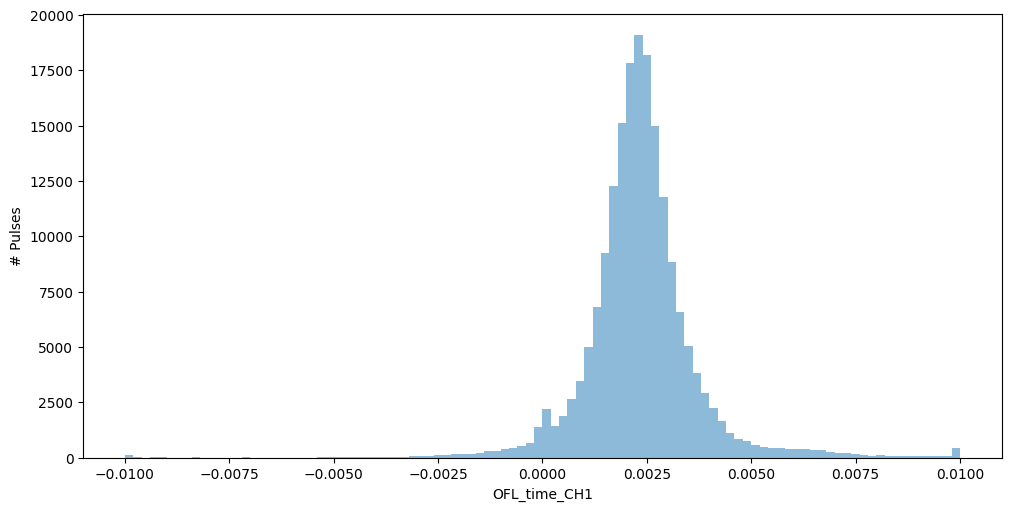

In [ ]:
# Plot a variable:
## settings
series = "Co60_August"
field = "OFL_time_CH1"
x_range = (-0.01,0.01)
bins=100
mask = source_dict[series]["data"]['trig_ch']==1
## --------

data = source_dict[series]["data"][field]
fig, ax = plt.subplots(1,1, figsize=(10,5), constrained_layout=True)

ax.hist(data[mask], range=x_range, bins=bins, alpha=0.5)
ax.set_xlabel(field)
ax.set_ylabel('# Pulses')